# Setup Notebook (Virtual machine)

In this section all required packages will be installed.

In [1]:
!apt-get update
!apt-get install -y swig python3-numpy python3-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python3-opengl libboost-all-dev libsdl2-dev
!pip install gymnasium==0.29.0 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
!pip install onnx onnx2pytorch==0.4.1
!pip install opencv-python pyvirtualdisplay

!wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
import utils


!pip install minigrid==2.0.0

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,848 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,083 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/res

In [2]:
import time
from datetime import datetime
import numpy as np
from collections import deque, namedtuple
import collections
import os
import time
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import gymnasium as gym
import gymnasium.spaces

import matplotlib.pyplot as plt
import copy
%matplotlib inline
!nvcc --version

from matplotlib import animation
import seaborn as sns; sns.set()
from IPython.display import clear_output, HTML
from IPython import display

import torch.onnx

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Mount your drive and use GPU

Here you can mount your GDrive folders (where you will store checkpoints during training).

In [3]:
if not os.path.exists('/content/gdrive'):
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Replay Buffer

The replay buffer stores transitions - state, action, reward, next_state.

In [5]:
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

class ReplayBuffer():
  def __init__(self, num_actions, memory_len = 10000):
      self.memory_len = memory_len
      self.transition = []
      self.num_actions = num_actions

  def add(self, state, action, reward, next_state, done):
      if self.length() > self.memory_len:
        self.remove()
      self.transition.append(Transition(state, action, reward, next_state, done))

  def sample_batch(self, batch_size = 32):
      minibatch = random.sample(self.transition, batch_size)
      states_mb, a_, reward_mb, next_states_mb, done_mb = map(np.array, zip(*minibatch))

      mb_reward = torch.from_numpy(reward_mb).to(device=device, dtype=torch.float32)
      mb_done = torch.from_numpy(done_mb.astype(int)).to(device=device)
      a_ = a_.astype(int)
      a_mb = np.zeros((a_.size, self.num_actions), dtype=np.float32)
      a_mb[np.arange(a_.size), a_] = 1
      mb_a = torch.from_numpy(a_mb).cuda().to(device=device)
      return states_mb, mb_a, mb_reward, next_states_mb, mb_done # states will be converted to tensors in forward pass

  def length(self):
      return len(self.transition)

  def remove(self):
      self.transition.pop(0)

# MINIGRID DQN-Training

This section contains the train function for the minigrid environment.

### Minigrid Environment and Policy Network





In [6]:
# Minigrid Environment
from minigrid.wrappers import ImgObsWrapper
class ChannelFirst(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        old_shape = env.observation_space.shape
        self.observation_space = {}
        self.observation_space = gym.spaces.Box(0, 255, shape=(3, 7, 7))

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32)

class MinigridEmpty5x5ImgObs(gym.Wrapper):
    """Minigrid with image observations provided by minigrid, partially observable."""
    def __init__(self, render=False):
        if render:
          env = gym.make('MiniGrid-Empty-5x5-v0', render_mode="rgb_array")
        else:
          env = gym.make('MiniGrid-Empty-5x5-v0')
        env = ScaledFloatFrame(ChannelFirst(ImgObsWrapper(env)))
        super().__init__(env)

class MinigridDoorKey6x6ImgObs(gym.Wrapper):
    """Minigrid with image observations provided by minigrid, partially observable."""
    def __init__(self, render=False):
        if render:
          env = gym.make('MiniGrid-DoorKey-6x6-v0', render_mode="rgb_array")
        else:
          env = gym.make('MiniGrid-DoorKey-6x6-v0')
        env = ScaledFloatFrame(ChannelFirst(ImgObsWrapper(env)))
        super().__init__(env)

In [7]:
env = MinigridDoorKey6x6ImgObs()
obs = env.reset()[0]
obs, obs.shape, env.action_space

(array([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 2., 2., 2., 0., 0.],
         [0., 0., 2., 5., 2., 0., 0.],
         [0., 0., 2., 1., 2., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 5., 5., 5., 0., 0.],
         [0., 0., 5., 4., 5., 0., 0.],
         [0., 0., 5., 0., 5., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], dtype=float32),
 (3, 7, 7),
 Discrete(7))

In [8]:
class MlpMinigridPolicy(nn.Module):
    def __init__(self, num_actions=7):
        super().__init__()
        self.num_actions = num_actions
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(3*7**2, 256), nn.ReLU(),
                                nn.Linear(256, 256), nn.ReLU(),
                                nn.Linear(256, 64), nn.ReLU(),
                                nn.Linear(64, num_actions))
    def forward(self, x):
        if len(x.size()) == 3:
          x = x.unsqueeze(dim=0)
        return self.fc(x)

### Training utils

In [9]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [10]:
def set_seed(env, seed=None):
    if seed is not None:
        random.seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


In [11]:
num_episodes = 1000 # number of episodes to run the algorithm -> the algorithm should reach a score of about 0.9 within 1000 episodes
buffer_size = 100000 # size of the buffer to use
epsilon = 1.0 # initial probablity of selecting random action a, annealed over time
timesteps = 0 # counter for number of frames
minibatch_size = 128 # size of the minibatch sampled
gamma = 0.99 # discount factor
eval_episode = 100
num_eval = 10
tau = 1e-3
learning_rate = 0.0001
update_after = 2000 # update after num time steps
epsilon_decay = 10000 # decay epsilon in 100.000 timesteps
epsilon_ub = 1.0
epsilon_lb = 0.3
# set seed
np.random.seed(0)
torch.manual_seed(0)

In [12]:
print(device)

cuda


### Load model (if available)

In [13]:
# specify load path if available:

# load_path = '/content/gdrive/MyDrive/colab-drive/minigrid-model-2022_03_28-10_01_18.p'

load_path = '' # otherwise start with randomly initialized agent

# save the current model state
save_path = f"/content/gdrive/MyDrive/colab-drive/minigrid-model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.p"
save_path = f"minigrid-model-{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}.p"

print(f'model checkpoints will be saved to: {save_path}')

def load_checkpoint(checkpoint_path='', device=device):
  dqn = MlpMinigridPolicy(num_actions=num_actions).to(device=device)
  dqn_target = MlpMinigridPolicy(num_actions=num_actions).to(device=device)
  timesteps = 0

  if checkpoint_path:
    print(f'Loading checkpoint {checkpoint_path}')
    checkpoint_dict = torch.load(checkpoint_path, map_location=device)
    model_params = checkpoint_dict['model_params']
    timesteps = checkpoint_dict['timesteps'] # environment steps

    dqn.load_state_dict(model_params) # makes a copy of model_params
    dqn_target.load_state_dict(model_params)
  else:
    print(f'Starting training from scratch.')

  return dqn, dqn_target, timesteps

def store_checkpoint(checkpoint_path, dqn_net, timesteps):
  checkpoint_dict = {'model_params':dqn_net.state_dict(), 'timesteps': timesteps}
  torch.save(checkpoint_dict, checkpoint_path)

model checkpoints will be saved to: minigrid-model-2024_05_15-22_58_10.p


In [14]:
# Initialize environment

# VERY IMPORTANT:
# Fast environment to build your code: MinigridEmpty5x5ImgObs() <- Train on this to improve your code fast.
# Actual environment for the exercise: MinigridDoorKey6x6ImgObs() <- Train on this for submitting on challenge server.
# Make sure to train on the right environment, when you are submitting your model.

env = MinigridDoorKey6x6ImgObs()

num_actions = env.action_space.n
state_space = env.observation_space.shape
print(num_actions, state_space)
obs, obs.shape, env.action_space

7 (3, 7, 7)


(array([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 2., 2., 2., 0., 0.],
         [0., 0., 2., 5., 2., 0., 0.],
         [0., 0., 2., 1., 2., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 5., 5., 5., 0., 0.],
         [0., 0., 5., 4., 5., 0., 0.],
         [0., 0., 5., 0., 5., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], dtype=float32),
 (3, 7, 7),
 Discrete(7))

In [15]:
# Update Target network
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter
    """
    # TODO: Update target network

    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    # ....

### DQN training loop

In [16]:
from torch.serialization import load

# Train the agent using DQN for Pong
returns = []
returns_50 = deque(maxlen=50)
losses = []
buffer = ReplayBuffer(num_actions=num_actions, memory_len=buffer_size)

dqn, dqn_target, timesteps = load_checkpoint(load_path)

optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
mse = torch.nn.MSELoss()
state = env.reset()[0]
for i in range(num_episodes):
  ret = 0
  done = False
  while not done:
    # Decay epsilon
    epsilon = max(epsilon_lb, epsilon_ub - timesteps/ epsilon_decay)
    # action selection
    if np.random.choice([0,1], p=[1-epsilon,epsilon]) == 1:
      a = np.random.randint(low=0, high=num_actions, size=1)[0]
    else:
      # state_tmp = state[np.newaxis, :].astype(np.float32)
      state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
      net_out = dqn(state_tensor).detach().cpu().numpy()
      a = np.argmax(net_out)
#    next_state, r, done, info = env.step(a)
    next_state, r, terminated, truncated, info = env.step(a)
    done = terminated or truncated
#    print(next_state.shape)
    ret = ret + r
    # TODO: store transition in replay buffer
    buffer.add(state, a, r, next_state, done)
    state = next_state
    timesteps = timesteps + 1

    # update policy using temporal difference
    if buffer.length() > minibatch_size and buffer.length() > update_after:
      optimizer.zero_grad()
      # TODO: Sample a minibatch randomly
      states_mb, mb_a, mb_reward, next_states_mb, mb_done = buffer.sample_batch(batch_size=minibatch_size)
      states_tensor = torch.tensor(states_mb, dtype=torch.float32, device=device)
      next_states_tensor = torch.tensor(next_states_mb, dtype=torch.float32, device=device)

      # TODO: Compute q values for states
      q_values = dqn(states_tensor)
      q_next = dqn_target(next_states_tensor).detach()
      # TODO: compute the targets for training
      targets = mb_reward + gamma * torch.max(q_next, dim=1)[0] * (1 - mb_done)
      # TODO: compute the predictions for training
      predicted_q_values = torch.sum(q_values * mb_a, dim=1)
      # TODO: Compute loss: mse = mean squared error
      loss = mse(predicted_q_values, targets)
      # print('predictions', predictions, 'targets', targets)
      # print(loss)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      # Update target network
      soft_update(dqn, dqn_target, tau)
    if done:
      state = env.reset()[0]
      print(f"Episode: \t{i}\t{ret}\t{datetime.now().strftime('%Y_%m_%d-%H_%M_%S')}")
      break
  returns.append(ret)
  returns_50.append(ret)
  if i % 50 == 0:
    store_checkpoint(checkpoint_path=save_path, dqn_net=dqn, timesteps=timesteps)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(returns_50)))

Starting training from scratch.
Episode: 	0	0	2024_05_15-22_58_11
Episode 0	Average Score: 0.00
Episode: 	1	0	2024_05_15-22_58_11
Episode: 	2	0.6724	2024_05_15-22_58_12
Episode: 	3	0	2024_05_15-22_58_12
Episode: 	4	0	2024_05_15-22_58_12
Episode: 	5	0	2024_05_15-22_58_12
Episode: 	6	0	2024_05_15-22_58_12
Episode: 	7	0	2024_05_15-22_58_12
Episode: 	8	0	2024_05_15-22_58_13
Episode: 	9	0	2024_05_15-22_58_14
Episode: 	10	0	2024_05_15-22_58_15
Episode: 	11	0	2024_05_15-22_58_16
Episode: 	12	0	2024_05_15-22_58_17
Episode: 	13	0.39879999999999993	2024_05_15-22_58_18
Episode: 	14	0	2024_05_15-22_58_19
Episode: 	15	0	2024_05_15-22_58_20
Episode: 	16	0	2024_05_15-22_58_21
Episode: 	17	0	2024_05_15-22_58_22
Episode: 	18	0	2024_05_15-22_58_23
Episode: 	19	0	2024_05_15-22_58_24
Episode: 	20	0	2024_05_15-22_58_25
Episode: 	21	0	2024_05_15-22_58_26
Episode: 	22	0.36640000000000006	2024_05_15-22_58_27
Episode: 	23	0	2024_05_15-22_58_28
Episode: 	24	0	2024_05_15-22_58_29
Episode: 	25	0.8092	2024_05_15-2

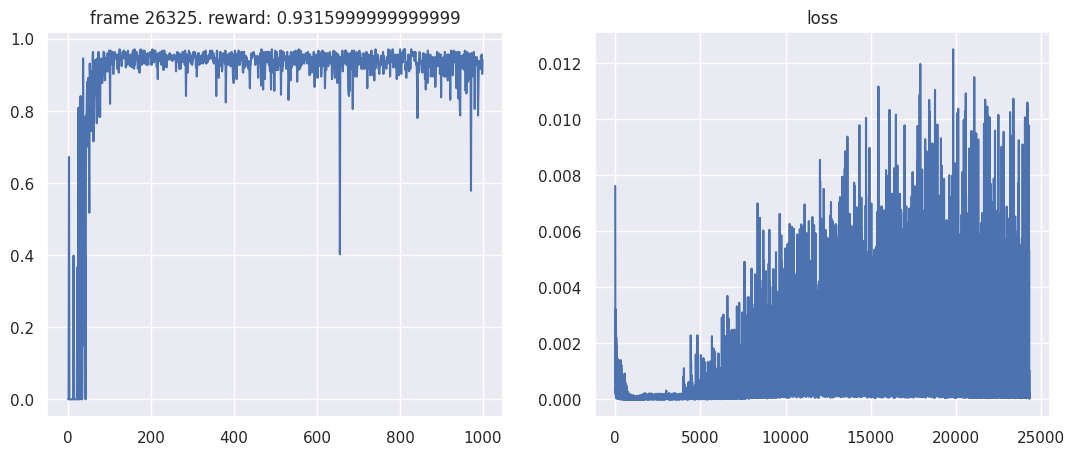

In [17]:
plot(timesteps, returns, losses)

Evaluate your model:

In [18]:
class Agent():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def select_action(self, state):
        state = np.expand_dims(state, 0)
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            q_action = self.model(state).detach().cpu().numpy()

            return np.argmax(q_action)

def run_episode(env, agent, seed=None):
    state = env.reset(seed=seed)[0]
    score = 0
    done = False
    while not done:
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
    env.close()
    return score

In [19]:
N_EPISODES = 50
agent = Agent(model=dqn, device=device)

scores = []
for i in range(N_EPISODES):
    seed = np.random.randint(1e7)
    scores.append(run_episode(env, agent, seed=seed))

# Print result
print("Average Return:", np.mean(scores))

Average Return: 0.96292


Convert model to ONNX for Submission:

In [20]:
def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(torch_model,             # model being run
                    sample_input,              # model input (or a tuple for multiple inputs)
                    f=model_path,              # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=17,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    )

In [21]:
sample_state = env.reset(seed=seed)[0]
save_as_onnx(dqn, torch.tensor(sample_state, dtype=torch.float32, device=device), 'submission_model_new.onnx')

In [22]:
# load the onnx model and test it:
import onnx
from onnx2pytorch import ConvertModel

dqn = ConvertModel(onnx.load('submission_model_new.onnx'))
dqn = dqn.to(device)
dqn.eval()

agent = Agent(model=dqn, device=device)

scores = []
for i in range(N_EPISODES):
    seed = np.random.randint(1e7)
    scores.append(run_episode(env, agent, seed=seed))


print("Average Return:", np.mean(scores))

/usr/local/lib/python3.10/dist-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


Average Return: 0.963712
